## Writeup

### You can use this file as a template for your writeup if you want to submit it as a markdown file, but feel free to use some other method and submit a pdf if you prefer.

---

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import writeup

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

** Code structure **

The code is organized in five files:
 * camera.py: implements camera calibration and perspective transformation
 * edges.py: implements edge extraction and centroids detection
 * lane.py: implements the actual lane detection
 * utils.py: utility functions
 * writeup.py: functions for writeup visualization

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

In the file **camera.py** are present 3 functions/classes:

 * `get_camera_calibration_params`: given a list of filenames, extracts chessboard corners applying `cv2.findChessboardCorners` on every grayscaled image, associates such corners to a fixed chessboard located on the (x, y) plane at z=0 and then call `cv2.calibrateCamera` to calculate the calibration parameters 
 * `undistort`: apply calibration parameters to an image using `cv2.undistort`
 * `Calibration`: class for managing, caching and applying calibration parameter; it exploits the previously described functions; the `__call__` method undistort the input image

Here is an example of of undistortion applied to one of the calibration images themselves:

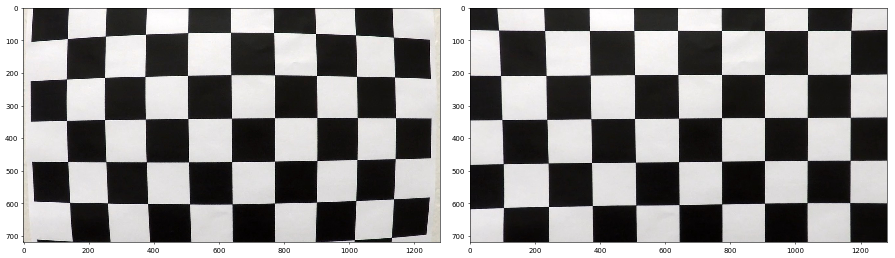

In [2]:
writeup.camera_calibration('./camera_cal/calibration1.jpg')

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

To apply the distortion correction is as simple as instantiate `camera.Calibration` with the calibration images filenames `./camera_cal/*` and using this object as a function.

Here is an example of calculating and applying the distortion correction:
```python
import glob
import cv2
import camera
calibrate = camera.Calibration(glob.glob('./camera_cal/*'))
calibrate(cv2.imread('./test_images/straight_lines1.jpg')[..., ::-1])
```
Here is a comparison between a distorted and undistorted image. The effect is particularly strong on the border of the image, like e.g. the green and white sign on the right.

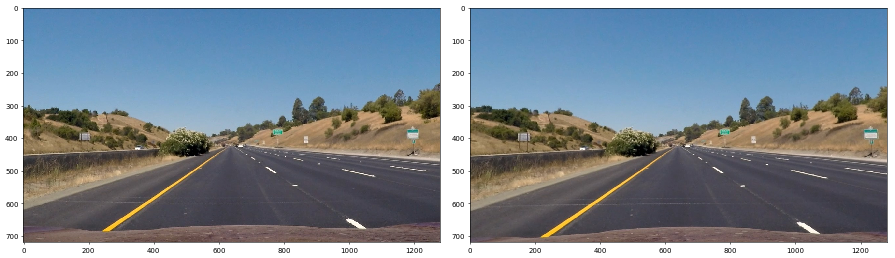

In [3]:
writeup.camera_calibration('./test_images/straight_lines1.jpg')

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of luminance, color and gradient thresholds to generate a binary image (thresholding steps at lines 4 through 34 in **`edges.py`**). I changed to the HLS space to calculate saturation and luminance. I calculated the x-gradient using the Scharr kernel (an improved version of Sobel).

Finally I combined the binary masks by **`and`**-ing the saturation and luminance thresholded channels and then **`or`**-ing the result with the thresholded x-gradient. I added the luminance channel threshold to the suggested saturation threshold because in dark areas, like deep shadows, the saturation calculation progressively becomes ill-posed.

Here's an example of my output for this step in false colors, where:
 * red represents the thresholded saturation channel
 * green represents the thresholded luminance channel
 * blue represents the thresholded x-gradient channel

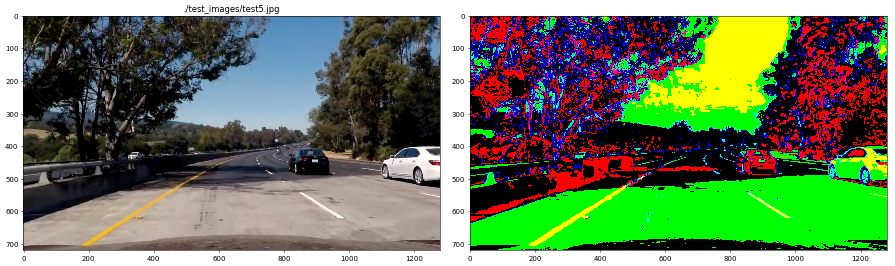

In [4]:
writeup.image_thresholding('./test_images/test5.jpg', rgb=True)

Red areas are those that are filtered out by the luminance threshold. The binary mask is composed by the blueish, yellow and white areas, giving the following.

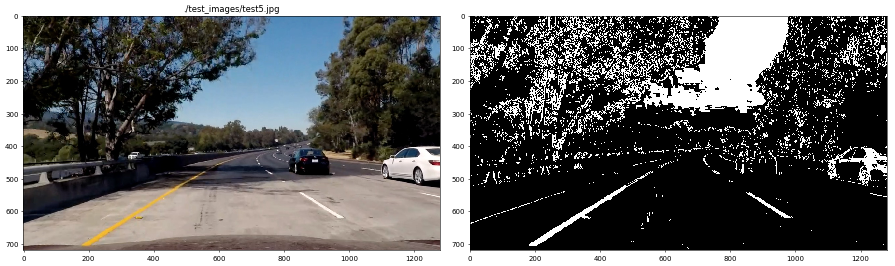

In [5]:
writeup.image_thresholding('./test_images/test5.jpg', rgb=False)

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

In **`camera.py`** (lines 59-97) you can find the following class:

  * `PerspectiveTransformation`: class for estimate, apply and invert a perspective transformation to an image or a set of points. It consists in:
    * `__init__`: needs source corners and correspondent output corners
    * `__call__`: apply transformation to an image or set of points (specified as $x$/$y$ coordinates)
    * `inverse`: property pointing to inverse transformation (source and destination corners swapped)

I estimated the source corners on the images `./test_images/straight_lines1.jpg` and `./test_images/straight_lines2.jpg`, and then averaged the result. <!--I cut the hood from the trasformation, in order to reduce false alarms.-->

I used as reference the center of the lines, because, although I used the undistorted images, the lane lines get wider when they are far from the camera. I impute this to the fact that, while the lines get thinner as they get farther in the original image, the edge spread function amounts always the same number of pixels, and therefore the perspective transformation seems to enlarge it.

As destination coordinates, I hard coded the value trying to have enough space on the side of the lines in order to detect them on the curves.

Here are the corners I used.

In [6]:
print("Source corners\n\t%s" % str(writeup.src_corners).replace('\n', '\n\t'))
print("Destination corners\n\t%s" % str(writeup.dest_corners).replace('\n', '\n\t'))

Source corners
	[[  212.5    720.  ]
	 [  573.75   465.  ]
	 [  711.     465.  ]
	 [ 1106.5    720.  ]]
Destination corners
	[[  280.   720.]
	 [  280.     0.]
	 [ 1000.     0.]
	 [ 1000.   720.]]


I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

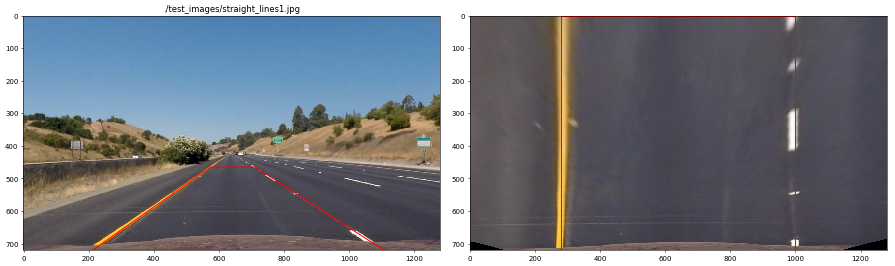

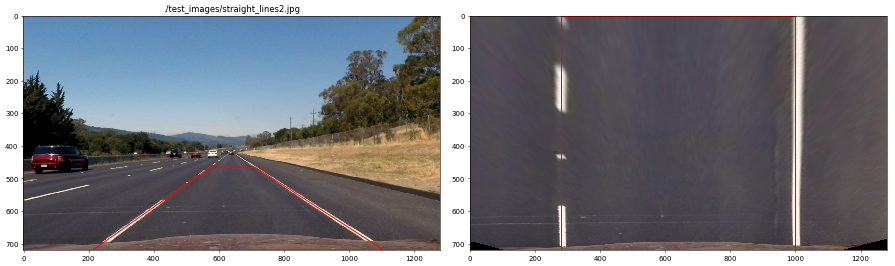

In [7]:
writeup.perspective('./test_images/straight_lines1.jpg')
writeup.perspective('./test_images/straight_lines2.jpg')

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

My final pipeline consisted in:
 1. Calibrate the image
 2. Warp the image to topdown view
 3. Threshold the image to detect edges<sup>1</sup>
 4. Apply morphological opening (square 9x9) and closing (square 9x9) in order to reduce the noise and consolidate the blobs (**`lane.py`** lines 195-196)
 5. Vertically split the image in two (left and right line)
 6. For each side
    1. Exponentially average the mask with the previous one
    2. Find the line centroids (see below)
    3. Fit a parabola on the centroids and estimate the curvature radius (see below)
    4. Draw the fitted line back on the calibrated image
 7. Draw the lane and its information back on the calibrated image
 
I identified the lane-line centroids (point 6B) by modifying the convolution approach exposed in the course (**`edges.py`** lines 39-99). Here is a brief description of my algorithm:

I divide the image in layers (nine, 80 pixels each) and, for each one:
  1. I perform a convolution with a box car filter 80 pixels wide.
  2. I take an image slice around a first guess got from either:
     1. An input polynomial fit (performed on a previous frame) calculated on the slice center.
     2. The position found in the previous layer. For the first layer (lines 51-61), I average the quarter bottom of the input mask and take the argmax. If in the previous layer no centroid was found, I increase the slice width (and I keep increasing it as long as no centroid is found at each layer).
     3. In the first layer, if no polynomial is provided and the layer is empty (all zero), than I use the (left/right) image center.
  3. I find the maximum location.
  4. I take a window around the found location (wide as the convolution kernel) and calculated the barycenter on the summed layer.

I then fit a second order polynomial $x = p(y)$ on the found barycenters (point 6C), both in pixel coordinates (for overlaying the line onto the image) and in meters (to estimate the position and the curvature radius). I used a thin wrapper around **`np.polyfit`** (**`utils.py`** lines 5-19) that takes the best fit (in terms of lowest root mean squared residuals) removing each time an input point. In this way, the fit is more robust to (single) outliers.

In the following figures you can see:
 * on the right, the filtered edges in white, the line centroids windows in transparent green and the fitted polynomial in red
 * on the left, the fitted polynomial (in red) and the identified lane (in transparent green) overlayed onto the original image warped to topdown view.
 
\[1\]: I decided to perform *first* the warp and *then* edge detection because, in this way, the possible kernel size are more consistent near and far from the camera.

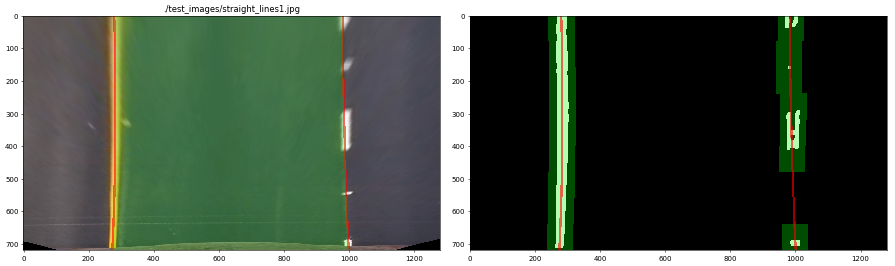

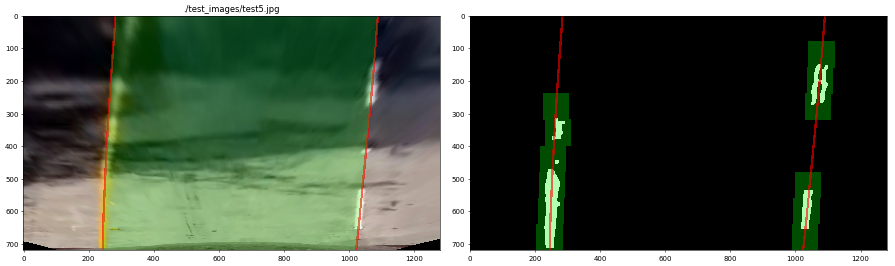

In [8]:
writeup.lines_detection('./test_images/straight_lines1.jpg')
writeup.lines_detection('./test_images/test5.jpg')

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

** Pixel size **

In order to have the measurements in physical units I had to estimate the pixel size of the images in topdown view.
For the x size is easy, as the distance between straight lines in topdown view is fixed and depends on my choice of destination corners in the perspective tranformation. So I only had to divide 3.7 meters by 720 (1280-280-280).
For the y size, I manually detected a dash in `./test_image/straight_lines1.jpg`, measured its length in the topdown view and divided 3 (meters) by this number. Here is a plot of the dash I used:

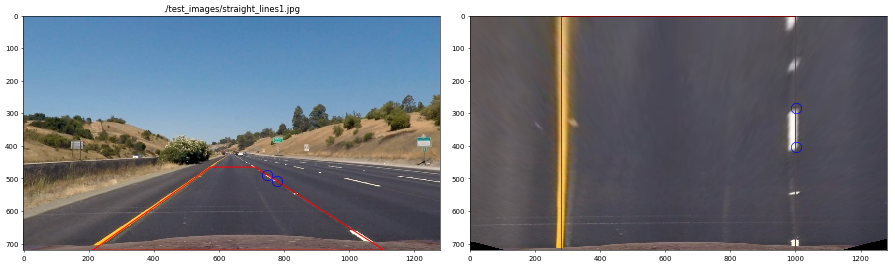

In [9]:
writeup.perspective('./test_images/straight_lines1.jpg', with_dash=True)

The values I obtained are:

In [10]:
writeup.xm_per_pix, writeup.ym_per_pix

(0.005138888888888889, 0.024528477382039091)

For comparison, the values suggested during the course where:

In [11]:
3.7 / 700, 30 / 720

(0.005285714285714286, 0.041666666666666664)

** Curvature **

To estimate the curvature radius, I apply the formula (**`lane.py`** lines 62-63):

$ R(y) = {(1 + p'(y)^2)^{3 / 2} \over p''(y)} $

I do not take the absolute value because, in this way, I can discriminate between right curves (positive radius) and left curves (negative radius).

** Position **

To estimate the position, I calculate the distance of the bottom of each line from the image vertical axis in topdown view. Then I computed the half-difference. The ratio is that, if $L$ and $R$ are such distances, ${L+R} \over 2$ is the lane center and $ L - {{L+R} \over 2} = {{L-R} \over 2} $ is the distance of the left line from the lane center.

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines 245 through 261 in my code in **`lane.py`** in the function **`draw_lane()`**.  Here is an example of my result on a test image:

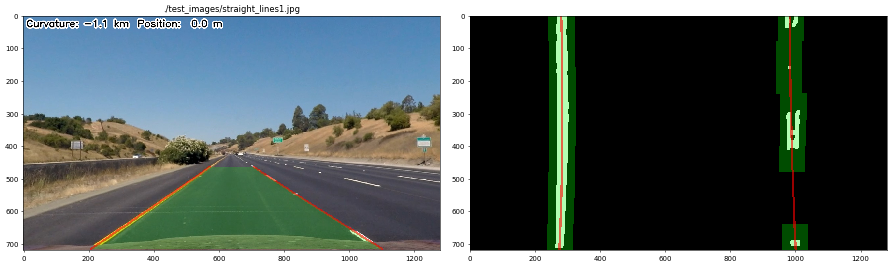

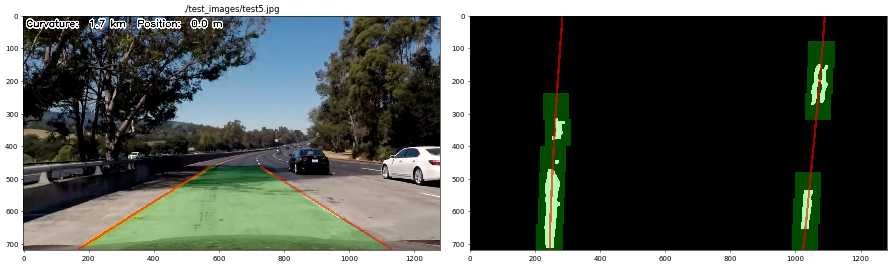

In [12]:
writeup.lines_detection('./test_images/straight_lines1.jpg', topdown_view=False, with_info=True)
writeup.lines_detection('./test_images/test5.jpg', topdown_view=False, with_info=True)

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

My final pipeline looks like:

In [13]:
writeup.get_source(writeup.process_image, writeup.process_video)

Here is the execution on the test video

In [14]:
writeup.process_video('project_video.mp4')

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [12:21<00:00,  1.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 



You can find my test video in the [./test_videos_output](./test_videos_output) directory or here below.
<video controls src="./test_videos_output/project_video.mp4" type="video/mp4" width="100%"/>
---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

With respect to the algorithms exposed during the course, I think my *best* additions were:
 1. The luminance thresholding: this greatly helped in reducing nearly to zero the noise of the mask. This was very important because in the video is present a small tree (second 37 approx., fifth test image) whose shadow looks saturated like the yellow line, which in turn, in that very section, was not detected. So the polynomial fit was mislead by it and took a too heavy curve.
 2. The mask averaging: at first a tried by averaging the polynomial fit, but I realized that by incresing the number of centroids the fit itself was going to be more robust, especially on the dashed line. Of course, the choice of the damping factor $\alpha$ is crucial, and strongly depends on the car speed (the faster the higher) and on the tortuosity. This dramatically showed up in the second challenge video where the fast deep curves make the algorithm go crazy.
 3. The centroid estimation is much more robust, do not assume to find something at each layer it succesfully exploit previous polynomial fits.

The generated mask are very good in my opinion. The only issue I see is that, sometimes, it seems to miss apparentely evident dashes especially in the lower part. The mask averaging helps a lot to reduce the introduced wobblying, so that it is quite neglegible.

With this good mask the centroid estimation rarely fails, but the polynomial fit on the left and right side very often disagree.

Other points I believe I would analyze if I were going to pursue this project further are:
 * consistency checks: I implemented some checks but, as I did not need these, I left them (-inf, inf)
 * the $\alpha$ parameter: I would try to dynamically change $\alpha$ by estimating the rate-of-change of the image (that is related to the car and curves speed)
 * tune the edge detection parameters and possibly algorithm to take into account different conditions (weather, illumination, occlusions, maybe night driving).